In [28]:
from torchvision.models import vgg16
import os 
from PIL import Image  # Image Load
import numpy as np
from matplotlib import pyplot #to show image
import xml.etree.ElementTree as ET # to get bndbox
import torch
from torch import nn
import torchvision # .opt.nms
import torch.nn.functional as F # softmax
from torch.utils.data import Dataset

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import tarfile

tar = tarfile.open("drive/MyDrive/voctar")
tar.extractall()
tar.close()

In [31]:
from torchvision.io import read_image

normalize = torchvision.transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImageDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data_dir = data_dir
    self.img_dir = os.path.join(data_dir, 'JPEGImages')
    self.anno_dir = os.path.join(data_dir, 'Annotations')
    self.ids = self.get_ids(self.img_dir)
    self.class_dict, self.class_names = self.get_dataset_info()
    self.transform = transform

  def get_ids(self, img_dir):
    ids = []
    for file_name in os.listdir(img_dir):
      ids.append(file_name.split('.')[0])
    ids.sort()
    return ids

  def get_dataset_info(self):
    class_dict = {}
    class_names = []
    class_idx = 0
    for id in self.ids:
      anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
      for obj in anno.findall('object'):
        class_name = obj.find('name').text
        if class_name not in class_dict:
          class_dict[class_name] = class_idx
          class_idx += 1
          class_names.append(class_name)
    return class_dict, class_names

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, i):
    if i >= len(self.ids): print("ERROR, size exceeded")
  
   
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = Image.open(img_file)
    image = np.transpose(image, (2, 0, 1))
    img_bndboxes = []
    img_classes = []

    #image = image.float()
    
    image = image / 256.
    image = torch.tensor(image, device=dev)#
    x = normalize(image)

    anno = ET.parse(os.path.join(self.anno_dir, id + '.xml'))
    for obj in anno.findall('object'):
      class_name = obj.find('name').text
      img_classes.append(self.class_dict[class_name])
      
      bndbox = obj.find('bndbox')
      img_bndboxes.append(
          [float(bndbox.find(tag).text) - 1 for tag in ('xmin', 'ymin', 'xmax', 'ymax')]
      )
    
    #print(image.shape)
    #x = torch.tensor(image, device=dev)#
    #print(X.shape)
    hh, ww = x.size(1), x.size(2)
    g_box = torch.tensor(img_bndboxes, device=dev)
    g_cls = torch.tensor(img_classes, device=dev)
    g_box[:, (0, 2)] /= ww
    g_box[:, (1, 3)] /= hh
    if self.transform:
      x = self.transform(x)
    
    sample = {"X":x, "G_box":g_box, "G_cls":g_cls}

    return sample
  
  def get_image(self, i):
    id = self.ids[i]
    img_file = os.path.join(self.img_dir, id + '.jpg')
    image = Image.open(img_file)
    return image

imageDataset = ImageDataset('VOCdevkit/VOC2007', torchvision.transforms.Resize((448, 448)))
print(imageDataset[0]['G_box'])

tensor([[0.5240, 0.5600, 0.6460, 0.9013],
        [0.3280, 0.7013, 0.5040, 0.9893],
        [0.0080, 0.6480, 0.1320, 0.9947],
        [0.4800, 0.5147, 0.5880, 0.7947],
        [0.5520, 0.4933, 0.6220, 0.5840]])


In [32]:
def batch_collate(batch_data):
  X = []
  G_imgidx, G_box, G_cls = [], [], []
  for i in range(len(batch_data)):
    ith_batch_data = batch_data[i]
    x, g_box, g_cls = ith_batch_data['X'], ith_batch_data['G_box'], ith_batch_data['G_cls']
    X.append(x)
    G_imgidx.append(torch.tensor([i]*len(g_box)))
    G_box.append(g_box)
    G_cls.append(g_cls)
  X = torch.stack(X, dim=0)
  G_imgidx = torch.cat(G_imgidx, dim=0)
  G_box = torch.cat(G_box, dim=0)
  G_cls = torch.cat(G_cls, dim=0)
  
  return X, G_box, G_cls, G_imgidx

from torch.utils.data import DataLoader
train_dl = DataLoader(imageDataset, batch_size=2, shuffle=False, collate_fn = batch_collate)#num_workers=1)
next(iter(train_dl))

(tensor([[[[-1.9283e+00, -1.9051e+00, -1.9424e+00,  ...,  6.8453e-01,
             6.6550e-01,  6.4646e-01],
           [-2.0170e+00, -1.9560e+00, -1.9407e+00,  ...,  6.3839e-01,
             6.3748e-01,  6.3282e-01],
           [-1.6447e+00, -1.8152e+00, -1.9056e+00,  ...,  6.4661e-01,
             6.4863e-01,  6.4863e-01],
           ...,
           [-1.5405e+00, -1.5528e+00, -1.5716e+00,  ..., -1.0938e+00,
            -1.0486e+00, -1.0515e+00],
           [-1.4232e+00, -1.3993e+00, -1.2364e+00,  ..., -1.0343e+00,
            -9.5696e-01, -9.4115e-01],
           [-1.2702e+00, -1.0417e+00, -7.8358e-01,  ..., -1.0510e+00,
            -9.6985e-01, -9.4190e-01]],
 
          [[-1.8747e+00, -1.8181e+00, -1.8461e+00,  ...,  1.2304e+00,
             1.2109e+00,  1.1914e+00],
           [-1.9406e+00, -1.8702e+00, -1.8521e+00,  ...,  1.2359e+00,
             1.2350e+00,  1.2302e+00],
           [-1.5124e+00, -1.7159e+00, -1.8113e+00,  ...,  1.2614e+00,
             1.2634e+00,  1.2634e+00],


In [85]:
#input : 448*448
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, input):
        return self.func(input)

X = torch.zeros((1, 3, 448, 448))
darknet = nn.Sequential(
  nn.Conv2d(3, 64, 7, stride=2, padding=3),
  nn.BatchNorm2d(64),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),
  
  nn.Conv2d(64, 192, 3, padding=1),nn.BatchNorm2d(192),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),
  

  nn.Conv2d(192, 128, 1),nn.BatchNorm2d(128),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(128, 256, 3, padding=1),nn.BatchNorm2d(256),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 256, 1),nn.BatchNorm2d(256),
  nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),nn.BatchNorm2d(512),
  nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(512, 256, 1),nn.BatchNorm2d(256), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True), 
  nn.Conv2d(512, 256, 1),nn.BatchNorm2d(256), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 256, 1),nn.BatchNorm2d(256), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 256, 1),nn.BatchNorm2d(256), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(256, 512, 3, padding=1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 512, 1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.MaxPool2d(2, stride=2),

  nn.Conv2d(1024, 512, 1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 512, 1),nn.BatchNorm2d(512), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(512, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, stride=2, padding=1), nn.LeakyReLU(0.1, inplace=True),

  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  nn.Conv2d(1024, 1024, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  
  nn.Conv2d(1024, 30, 3, padding=1), nn.LeakyReLU(0.1, inplace=True),
  Lambda(lambda x:x.permute(0, 2, 3, 1))
  
  #Lambda(lambda x: x.view(-1, 1024*7*7)),
  #7*7*1024
  #nn.Linear(7*7*1024, 4096), nn.LeakyReLU(0.1, inplace=True),
  #nn.Dropout(p=0.5),
  #nn.Linear(4096, 7*7*30),
  #Lambda(lambda x: x.view(-1, 7, 7, 30)),
)

C=20
S=7
B=2
conv_cls = nn.Linear(4096, 7*7*C)
conv_box = nn.Linear(4096, 7*7*B*4)
conv_conf = nn.Linear(4096, 7*7*B)
'''
H = darknet(X)
H_cls = H[:, :, :, :C]
H_cls = H_cls.view(-1, S*S, C)
H_box = H[:, :, :, C:C+B*4]
H_box = H_box.view(-1, S*S, B, 4)
H_conf = H[:, :, :, C+B*4:]
H_conf = H_conf.view(-1, S*S, B)
#darknet[:24], nn.AvgPool2d
'''

'\nH = darknet(X)\nH_cls = H[:, :, :, :C]\nH_cls = H_cls.view(-1, S*S, C)\nH_box = H[:, :, :, C:C+B*4]\nH_box = H_box.view(-1, S*S, B, 4)\nH_conf = H[:, :, :, C+B*4:]\nH_conf = H_conf.view(-1, S*S, B)\n#darknet[:24], nn.AvgPool2d\n'

In [34]:
N=1
Q = 4

G_box = torch.zeros((N, Q, 4))
G_center = torch.zeros((N, Q, 2))
Y_Gbox = (G_center[:, :, 0]/64).int() + (G_center[:, :, 1]/64).int() * 64
G_cls = torch.zeros((N, Q))

#Anchor = 
Y_box = torch.zeros((N, 7*7, 4))
448/7
print(np.linspace(0, 1, num=7, endpoint=False))
_y_center = np.linspace(0, 1, num=7, endpoint=False) + (1/7)*0.5
_y_center_x = _y_center[None, :] + np.zeros(S)[:, None]
_y_center_y = _y_center[:, None] + np.zeros(S)[None, :]

y_center = np.stack((_y_center_x, _y_center_y), axis=2)
y_center= np.reshape(y_center, (-1, 2))
y_center = torch.from_numpy(y_center).to(dev)
y_center.shape




[0.         0.14285714 0.28571429 0.42857143 0.57142857 0.71428571
 0.85714286]


torch.Size([49, 2])

In [ ]:
_y_box_list = []
_y_obj_list = []
_y_cls_list = []

for i in range(N):
  g_box = G_box[i]
  g_cls = G_cls[i]
  g_center = G_center[i]

  y_obj = torch.zeros((7*7))
  y_cls = torch.zeros((7*7), dtype=torch.long)
  y_gbox = -torch.ones((7*7), dtype=torch.long)
  y_box = torch.zeros((7*7, 4))
  _target_anchor = (g_center[:, 0] / 64).long() + (g_center[:, 1] / 64).long() * 64
  y_gbox[_target_anchor] = torch.arange(len(g_box))
  y_obj[_target_anchor] = 1
  #print(y_gbox)
  y_box[y_obj == 1] = g_box[y_gbox[y_obj == 1]]

  y_cls[y_obj == 1] = g_cls[y_gbox[y_obj == 1]]
  _y_box_list.append(y_box)
  _y_obj_list.append(y_obj)
  _y_cls_list.append(y_cls)
#print(torch.tensor(_y_box_list))
Y_box = torch.stack(_y_box_list, dim=0)
Y_obj = torch.stack(_y_obj_list, dim=0)
Y_cls = torch.stack(_y_cls_list, dim=0)
#Y_cls = F.logsoftmax(Y_cls, axis=-1)


RuntimeError: ignored

In [ ]:
B=2

def get_maxiougbox_mask(H_box, G_box, Y_box, Y_obj):
  Y_obj_ij = torch.zeros((N, 7*7, B)).to(dev)
  for i in range(N):
    h_box = H_box[i]
    g_box = G_box[i]
    y_box = Y_box[i]
    #-iou-#
    #print(h_box.device, y_box.device)
    tl = torch.maximum(h_box[:, :, :2], y_box[:, None, :2]) # 49 2 2
    br = torch.minimum(h_box[:, :, 2:], y_box[:, None, 2:])

    iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1) # 49 2
    iou_a = torch.prod(h_box[:, :,  2:] - h_box[:, :, :2], axis=-1) # 49 2
    iou_b = torch.prod(y_box[:, 2:] - y_box[:, :2], axis=-1, keepdim=True) # 49 1
    iou = iou_inter / (iou_a + iou_b - iou_inter) # 49 2

    _argmax_of_hbox = torch.argmax(iou, axis=1)
    Y_obj_ij[i, :, :] = F.one_hot(_argmax_of_hbox, num_classes=2)
  return Y_obj_ij * Y_obj[:, :, None]

#Y_obj_ij = get_maxiougbox_mask(H_box, G_box, Y_box, Y_obj)
#Y_conf = Y_obj_ij
#Y_obj_ij.shape

#fancy selecting vs 

In [35]:
def sum_sq_error(X, mask):
  loss = torch.pow(X, 2) * mask
  return torch.sum(loss)

In [ ]:
l_coord = 5
l_noobj = 0.5

print(H_box.shape, Y_box.shape, Y_obj.shape)
print(H_conf.size(), Y_conf.size(), Y_obj_ij.shape)

l1 = l_coord * sum_sq_error(H_box[:, :, :, 0] - Y_box[:, :, None, 0], Y_obj_ij)
l2 = l_coord * sum_sq_error(H_box[:, :, :, 1] - Y_box[:, :, None, 1], Y_obj_ij)
l3= l_coord * sum_sq_error(torch.sqrt(abs(H_box[:, :, :, 2]) + 1e-6) - torch.sqrt(abs(Y_box[:, :, None, 2]) + 1e-6),
                           Y_obj_ij)
l4= l_coord * sum_sq_error(torch.sqrt(H_box[:, :, :, 3]) - torch.sqrt(Y_box[:, :, None, 3]), Y_obj_ij)
l5=  sum_sq_error(H_conf - Y_conf, Y_obj_ij == 1)
l6=  l_noobj * sum_sq_error(H_conf - Y_conf, Y_obj_ij == 0)
l7=  sum_sq_error(H_cls - F.one_hot(Y_cls, num_classes=C), Y_obj[:, :, None])
L = l1 + l2 + l3 + l4 + l5 + l6 + l7


NameError: ignored

In [87]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
darknet.to(dev)
#list(p for p in darknet.parameters())[-4:]
opt = torch.optim.Adam(
    darknet.parameters(), lr=0.00001, #weight_decay = 0.0005 #this caused error
)

In [45]:
opt = torch.optim.Adam(
    vggmodel.parameters(), lr=0.00001, #weight_decay = 0.0005 #this caused error
)

In [ ]:
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda= lambda epoch:
                                              1 if epoch < 1 else \
                                              10 if epoch < 75 else \
                                              1 if epoch < 105 else \
                                              0.1 if epoch < 135 else 1
)

In [ ]:
def max_iou_idx(h_box, y_box):
  #-iou-#
  #print(h_box.device, y_box.device)
  tl = torch.maximum(h_box[:, :, :2], y_box[:, None, :2]) # 49 2 2
  br = torch.minimum(h_box[:, :, 2:], y_box[:, None, 2:])

  iou_inter = torch.all(tl < br, axis=-1) * torch.prod(br-tl, axis=-1) # 49 2
  iou_a = torch.prod(h_box[:, :,  2:] - h_box[:, :, :2], axis=-1) # 49 2
  iou_b = torch.prod(y_box[:, 2:] - y_box[:, :2], axis=-1, keepdim=True) # 49 1
  iou = iou_inter / (iou_a + iou_b - iou_inter) # 49 2

  argmax_of_hbox = torch.argmax(iou, axis=1)
  #print(f'argmax_of_hbox.shape, {argmax_of_hbox.shape}')
  return argmax_of_hbox

In [ ]:
i=0

G_center = torch.stack(((G_box[:, 0] + G_box[:, 2])/2,
                          (G_box[:, 1] + G_box[:, 3])/2), axis=1)

target_idx = ((G_center[:, 0]-1)*7).long() + ((G_center[:, 1]-1)*7).long() * 7
ith_batch_idx = (G_imgidx == i).nonzero()

g_target_idx = target_idx[ith_batch_idx]
g_box = G_box[ith_batch_idx]
g_cls = G_cls[ith_batch_idx]

#Y_box, Y_cls
Y_box[i][g_target_idx] = g_box
Y_cls[i][g_target_idx] = g_cls
Y_obj[i][g_target_idx] = 1
Y_obj_ij[i][F.one_hot(max_iou_idx(h_box, g_box), num_classes=2)] = 1


NameError: ignored

In [54]:
vgg16 = torchvision.models.vgg16(pretrained=False)
vgg16.to(dev)
vggmodel = nn.Sequential(
    vgg16.features,
    nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
    nn.Conv2d(512, C+B*4+B, 3, stride=1, padding=1),
    Lambda(lambda x: x.permute(0, 2, 3, 1))
).to(dev)

In [ ]:
class Convs(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_cls = nn.Conv2d(512, C, 1).to(dev)
    self.conv_box_offset = nn.Conv2d(512, B*4, 1).to(dev)
    self.conv_conf = nn.Conv2d(512, B, 1).to(dev)

  def forward(self, H):
    H_cls = self.conv_cls(H)
    H_box_offset = self.conv_box_offset(H)
    H_conf = self.conv_conf(H)
    H_cls = H_cls.permute(0, 2, 3, 1)
    H_box_offset = H_box_offset.permute(0, 2, 3, 1)
    H_conf = H_conf.permute(0, 2, 3, 1)
    return H_cls, H_box_offset, H_conf
convs = Convs().to(dev)
param1 = [p for p in vggmodel.parameters()]
param2 = [p for p in convs.parameters()]


In [ ]:
opt = torch.optim.Adam(
    param1+param2, lr=0.00001, #weight_decay = 0.0005 #this caused error
)

NameError: ignored

In [ ]:
vggmodel = torch.load('md1')

FileNotFoundError: ignored

In [61]:
for p in darknet.parameters():
  #print(p.data) #already initialized
  nn.init.uniform_(p.data, a=-0.0001, b=0.0001)

In [88]:
C = 20
S = 7
B = 2
N = 2
l_coord = 5
#print(f'darknet {[param for param in darknet.parameters()] }')

n_epochs = 500
darknet.train()
vggmodel.train()
convs.train()
for epoch_idx in range(n_epochs):
  
  for batch_idx, data in enumerate(train_dl):
    
    #print(X)
    X, G_box, G_cls, G_imgidx = data
    N = len(X)
    #print(X.shape, X.dtype)
    #print(X, G_box, G_cls)
    X.to(dev), G_box.to(dev), G_cls.to(dev)
    
    opt.zero_grad()
    X.detach_()
    H = darknet(X.float())
    #H = vggmodel(X.float())
    #H_cls, H_box_offset, H_conf=convs(H)

    #print(f'H: {H.shape}')
    dknet = True
    if dknet:
      H_cls = H[:, :, :, :C]
      H_box_offset = H[:, :, :, C:C+B*4]
      H_conf = H[:, :, :, C+B*4:C+B*4+B]
      
    H_cls = H_cls.view(-1, S*S, C)
    H_cls = F.softmax(H_cls, dim=-1)
      
  #  H_box_offset = torch.sigmoid(H_box_offset)
    H_box_offset = H_box_offset.view(-1, S*S, B, 4)
      
    H_conf = H_conf.view(-1, S*S, B)
    H_conf = torch.sigmoid(H_conf)
    #print(H_box_offset.shape)
    _H_box = H_box_offset.view(N, S*S, B, 2, 2) + y_center[None, :, None, None, :]
    H_box = _H_box.view(N, S*S, B, 4)


    G_center = torch.stack(((G_box[:, 0] + G_box[:, 2])/2,
                              (G_box[:, 1] + G_box[:, 3])/2), axis=1)
    G_sqrwh = torch.stack(((G_box[:, 2] - G_box[:, 0]),
                           G_box[:, 3] - G_box[:, 1]), axis=1)
    _G_box = torch.stack((G_center, G_sqrwh), axis=1).view(-1, 4)
######    
    
    #print(G_center[:, 0].shape, _y_center.shape)
    _y_split = torch.linspace(start=1/7, end=1, steps=7).to(dev) 
    _x_off = _y_split[None, :] < G_center[:, 0, None]
    _y_off = _y_split[None, :] < G_center[:, 1, None]
    target_idx = (torch.sum(_x_off, dim=-1) + torch.sum(_y_off, dim=-1) * 7).long()
    #print(target_idx)
    #break

######
    Y_box = torch.zeros((N, S*S, 4)).to(dev)
    Y_cls = torch.zeros((N, S*S)).long().to(dev)
    Y_obj = torch.zeros((N, S*S)).to(dev)
    Y_obj_ij = torch.zeros((N, S*S, B)).to(dev)
  
    



    for i in range(N):

      ith_batch_idx = (G_imgidx == i).nonzero()
      g_target_idx = target_idx[ith_batch_idx]
      g_box = _G_box[ith_batch_idx]
      g_cls = G_cls[ith_batch_idx]
      h_box = H_box[i]

      #Y_box, Y_cls
      Y_box[i][g_target_idx] = g_box
      Y_cls[i][g_target_idx] = g_cls
      Y_obj[i][g_target_idx] = 1
      #print(F.one_hot(max_iou_idx(h_box, Y_box[i]), num_classes=2).shape)
      Y_obj_ij[i] = F.one_hot(max_iou_idx(h_box, Y_box[i]), num_classes=2) \
        * Y_obj[i, :, None] #N, 49, 2 -- N, 49
    Y_conf = Y_obj_ij
    #print((Y_obj_ij == 1).sum())
    #print(H_box)
    #print(f'YCLS{Y_cls},\n YOBJ{Y_obj}\n YIJ{Y_obj_ij}')
    #break
    
    Y_box.detach_()
    Y_conf.detach_()
    Y_obj_ij.detach_()
    Y_cls.detach_()


    l1 = l_coord * sum_sq_error(H_box[:, :, :, 0] - Y_box[:, :, None, 0], Y_obj_ij)
    l2 = l_coord * sum_sq_error(H_box[:, :, :, 1] - Y_box[:, :, None, 1], Y_obj_ij)
    l3= l_coord * sum_sq_error(torch.sqrt(torch.sigmoid(H_box[:, :, :, 2]) + 1e-6) \
      - torch.sqrt(Y_box[:, :, None, 2]), Y_obj_ij)
    l4= l_coord * sum_sq_error(torch.sqrt(torch.sigmoid(H_box[:, :, :, 3]) + 1e-6) \
      - torch.sqrt(Y_box[:, :, None, 3]), Y_obj_ij)
    l5=  sum_sq_error(H_conf - Y_conf, Y_obj_ij == 1)
    l6=  l_noobj * sum_sq_error(H_conf - Y_conf, Y_obj_ij == 0)
    l7=  sum_sq_error(H_cls - F.one_hot(Y_cls, num_classes=C), Y_obj[:, :, None])
    L = l1 + l2 + l3 + l4 + l5 + l6 + l7
    #print(H_conf, H_cls)
    print(batch_idx, L.item(), l1, l2, l3, l4, l5, l6, l7)
    #print(H_conf)
    L.backward()
    #print(opt.param_groups)

    nn.utils.clip_grad_norm_(vggmodel.parameters(), max_norm=2.0, norm_type=2)
    opt.step()
    #print(f'{(Y_obj == 1).sum()},\n\n {(H_box[:, :, :, 0] - Y_box[:, :, None, 0])*Y_obj_ij} \n\n Y_conf:{H_conf}')
    break
  
  
 # scheduler.step()
   # N S*S 4, S*S 2
mdl1 = torch.save(vggmodel, f='mdl1')
mdl2 = torch.save(convs, f='mdl2')

0 38.71199636187549 tensor(0.0621, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0756, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.8885, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(2.7016, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(1.4998, grad_fn=<SumBackward0>) tensor(23.7857, grad_fn=<MulBackward0>) tensor(5.6986, grad_fn=<SumBackward0>)
0 38.579651977447284 tensor(0.0487, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0747, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.8877, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(2.6776, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(1.5059, grad_fn=<SumBackward0>) tensor(23.6897, grad_fn=<MulBackward0>) tensor(5.6954, grad_fn=<SumBackward0>)
0 38.51217932852846 tensor(0.0394, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(0.0733, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(4.8857, dtype=torch.float64, grad_fn=<MulBackward0>) tensor(2.6734, dtype=torch.float64, grad_fn

KeyboardInterrupt: ignored

In [ ]:
print(y_center[42],)
print(G_center[4])
print(linalg)

tensor([0.0714, 0.9286], device='cuda:0', dtype=torch.float64)
tensor([0.5870, 0.5387], device='cuda:0')


torch.Size([98, 4])
25 tensor([0.6175, 0.4705, 0.2750, 0.1744], dtype=torch.float64) 26 tensor([1.7829, 0.9312, 1.0950, 0.4897], dtype=torch.float64)
tensor([39, 37, 35, 31, 25, 25])
torch.Size([98, 4])
25 tensor([0.6195, 0.4666, 0.2097, 0.1212], dtype=torch.float64) 26 tensor([2.0671, 0.8090, 1.1901, 0.4849], dtype=torch.float64)
tensor([39, 37, 35, 31, 25, 25])


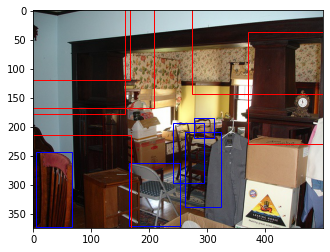

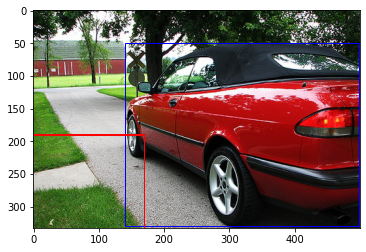

In [93]:
def predict(i, darknet):
  N=1
  data = imageDataset[i]
  #print(data)
  X, G_box, G_cls = data["X"], data["G_box"], data["G_cls"]
  #print(X.shape)
  #print(X)
  X = X[None, :]
  G_box = G_box[None, :]
  G_cls = G_cls[None, :]
  #print(X.shape)
  darknet.eval()
  with torch.no_grad():
    
    H = darknet(X.float())
    
    #H = vggmodel(X.float())
    #H_cls, H_box_offset, H_conf=convs(H)

    #print(f'H: {H.shape}')
    dknet = True
    if dknet:
      H_cls = H[:, :, :, :C]
      H_box_offset = H[:, :, :, C:C+B*4]
      H_conf = H[:, :, :, C+B*4:C+B*4+B]
    H_cls = H_cls.view(-1, S*S, C)
    H_cls = F.softmax(H_cls, dim=-1)
    H_box_offset = H_box_offset.view(-1, S*S, B, 4)
    H_conf = H_conf.view(-1, S*S, B)
    H_conf = torch.sigmoid(H_conf)
    #print(H_box_offset.shape)
    _H_box = H_box_offset.view(N, S*S, B, 2, 2) + y_center[None, :, None, None, :]
    H_box = _H_box.view(N, S*S, B, 4)
    
    '''#print(X.float())
    #X=torch.zeros_like(X)
    H = vggmodel(X.float().to(dev))
    H = H.permute(0, 2, 3, 1)
    H_cls = H_cls.permute(0, 2, 3, 1)
    H_box_offset = H_box_offset.permute(0, 2, 3, 1)
    H_conf = H_conf.permute(0, 2, 3, 1)
    #print(H)
   # print(f'H: {H}\n, H.shape: {H.shape}')
    H_cls = H[:, :, :, :C]
    H_cls = H_cls.view(-1, S*S, C)
    H_box_offset = H[:, :, :, C:C+B*4]
    H_box_offset = H_box_offset.view(-1, S*S, B, 4)
    H_conf = H[:, :, :, C+B*4:]
    H_conf = H_conf.view(-1, S*S, B)
    H_conf = torch.sigmoid(H_conf)


    _H_box = H_box_offset.view(N, S*S, B, 2, 2) + y_center[None, :, None, None, :]
    H_box = _H_box.view(N, S*S, B, 4)
    '''
    H_conf = H_conf.reshape(S*S*B)
    H_box = H_box.reshape(S*S*B, 4)
   # print(H_box[42][0:2], torch.sigmoid(H_box[42][2:4]))
    H_cls = H_cls.reshape(S*S, C)
    conf_lb = 0.5
    print(H_box.shape)
    print(25, H_box[50].data, 26, H_box[51].data)
    H_box = H_box[H_conf > conf_lb]
    H_cls = H_cls[torch.any(H_conf.reshape(S*S, B) > conf_lb, dim=1)]
    H_conf = H_conf[H_conf > conf_lb]
    
  #  print(H_box.shape)
   # print(H_conf.dtype)


    pred_boxes_indices = torchvision.ops.nms(boxes=H_box.float(), scores=H_conf, iou_threshold=0.7)
    Y_pred_boxes = H_box[pred_boxes_indices]
    Y_pred_cls = H_cls[(pred_boxes_indices/B).long()]
    Y_boxes = G_box.view(-1, 4)
    Y_cls = G_cls.view(-1)

    print(target_idx)
    image = np.array(imageDataset.get_image(i))
    hh = image.shape[0]
    ww = image.shape[1]
    import matplotlib.pyplot as plt
    from matplotlib.patches import Rectangle
    fig = plt.figure(i)
    #print(X[1].shape)
    plt.imshow(image)
    
    #plt.plot(y_center[:, 0].cpu().numpy()*ww, y_center[:, 1].cpu().numpy()*hh, 'o')
    for j in range(len(Y_boxes)):
      g_box = Y_boxes[j]
      xx = g_box[0] * ww
      xy = g_box[1] * hh
      yx = g_box[2] * ww
      yy = g_box[3] * hh
      w = yx-xx
      h = yy-xy
      plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='b',facecolor='none'))
    
    
    for j in range(len(Y_pred_boxes)):
      pred_box = Y_pred_boxes[j]
      xc = pred_box[0] * ww
      yc = pred_box[1] * hh
      w = torch.sigmoid(pred_box[2]) * ww
      h = torch.sigmoid(pred_box[3]) * hh
      xx = xc - w/2
      xy = yc - h/2
      #print(xx, xy, w, h)
     
      plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r',facecolor='none'))
    
    return H

h1 = predict(0, darknet)
h2 = predict(1, darknet)
#print(h1==h2)
#print(darknet[:-3])

In [ ]:
vgg16.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

for i in range(len(Y_pred_boxes)):
  fig = plt.figure(i)
  plt.imshow(images[i])
  pred_boxes = Y_pred_boxes[i]
  a_boxes = A_boxes[i]
  for j in range(len(pred_boxes)):
    pred_box = pred_boxes[j]
    xx = pred_box[0]
    xy = pred_box[1]
    yx = pred_box[2]
    yy = pred_box[3]
    w = yx-xx
    h = yy-xy
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='r',facecolor='none'))
  g_boxes = G_boxes[i]
  for j in range(len(g_boxes)):
    g_box = g_boxes[j]
    xx = g_box[0]
    xy = g_box[1]
    yx = g_box[2]
    yy = g_box[3]
    w = yx-xx
    h = yy-xy
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='b',facecolor='none'))
  """for j in range(len(a_boxes)):
    a_box = a_boxes[j]
    xx = a_box[0]
    xy = a_box[1]
    yx = a_box[2]
    yy = a_box[3]
    w = yx-xx
    h = yy-xy
    plt.gca().add_patch(Rectangle((xx,xy),w,h,linewidth=1,edgecolor='g',facecolor='none'))
  """